<a href="https://colab.research.google.com/github/fhzh123/CAU_mAI/blob/main/Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 및 자연어 처리를 위한 딥러닝 실습

## Neural Machine Translation with Attention

### 데이터 다운로드 및 라이브러리 다운로드

In [1]:
!pip install torchtext==0.6.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.6 MB/s eta 0:00:00


In [2]:
!python -m spacy download en_core_web_sm --quiet
!python -m spacy download de_core_news_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 72.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset

!gzip -d multi30k-dataset/data/task1/raw/train.en.gz
!gzip -d multi30k-dataset/data/task1/raw/train.de.gz
!gzip -d multi30k-dataset/data/task1/raw/val.en.gz
!gzip -d multi30k-dataset/data/task1/raw/val.de.gz
!gzip -d multi30k-dataset/data/task1/raw/test_2016_flickr.en.gz
!gzip -d multi30k-dataset/data/task1/raw/test_2016_flickr.de.gz
!mv multi30k-dataset/data/task1/raw/test_2016_flickr.de multi30k-dataset/data/task1/raw/test2016.de
!mv multi30k-dataset/data/task1/raw/test_2016_flickr.en multi30k-dataset/data/task1/raw/test2016.en

Cloning into 'multi30k-dataset'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 313 (delta 17), reused 21 (delta 16), pack-reused 281 (from 1)
Receiving objects: 100% (313/313), 18.21 MiB | 23.07 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Submodule 'scripts/subword-nmt' (https://github.com/rsennrich/subword-nmt.git) registered for path 'scripts/subword-nmt'
Cloning into '/content/multi30k-dataset/scripts/subword-nmt'...
remote: Enumerating objects: 622, done.        
remote: Counting objects: 100% (46/46), done.        
remote: Compressing objects: 100% (30/30), done.        
remote: Total 622 (delta 25), reused 31 (delta 16), pack-reused 576 (from 1)        
Receiving objects: 100% (622/622), 261.27 KiB | 4.15 MiB/s, done.
Resolving deltas: 100% (374/374), done.
Submodule path 'scripts/subword-nmt': checked out '80b7c1449e2e26673fb0b5cae993fe2d0dc23846'


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import spacy
import numpy as np
import random
from tqdm import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_datasets(batch_size=128):
    # 언어 파일을 다운로드하고 로드합니다.
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

    # 독일어 토크나이저를 정의합니다.
    def tokenize_de(text):
        return [token.text for token in spacy_de.tokenizer(text)]

    # 영어 토크나이저를 정의합니다.
    def tokenize_en(text):
        return [token.text for token in spacy_en.tokenizer(text)]

    # PyTorch의 Field를 생성합니다.
    source = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

    # 데이터셋을 학습, 검증, 테스트 데이터로 분할합니다.
    train_data, valid_data, test_data = Multi30k.splits(path='multi30k-dataset/data/task1/raw',
                                                        exts=(".de", ".en"),
                                                        fields=(source, target))

    # 학습 데이터에 대해 각 언어의 어휘(vocabulary)를 빌드합니다.
    source.build_vocab(train_data, min_freq=3)
    target.build_vocab(train_data, min_freq=3)

    # PyTorch의 BucketIterator를 사용하여 데이터셋을 배치 단위로 생성합니다.
    # 이때 sort_within_batch 옵션으로 배치 내에서 문장의 길이에 따라 정렬합니다.
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                          batch_size=batch_size,
                                                                          sort_within_batch=True,
                                                                          sort_key=lambda x: len(x.src),
                                                                          device=device)
    return train_iterator, valid_iterator, test_iterator, source, target


In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, encoder_hidden_dim, n_layers=1, dropout_prob=0.5):
        super().__init__()

        # 단어 집합 크기와 임베딩 차원을 기반으로 임베딩 레이어를 생성합니다.
        self.embedding = nn.Embedding(vocab_len, embedding_dim)

        # GRU 기반 RNN 레이어를 정의합니다.
        # 입력 크기는 임베딩 차원이며, 은닉 상태 크기와 계층 수, 드롭아웃 확률을 설정합니다.
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, n_layers, dropout=dropout_prob)

        # 드롭아웃 레이어를 설정합니다.
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        # 입력 데이터를 임베딩하고 드롭아웃을 적용합니다.
        embedded = self.dropout(self.embedding(input_batch))

        # RNN에 임베딩된 데이터를 입력하여 출력과 은닉 상태를 얻습니다.
        outputs, hidden = self.rnn(embedded)

        # RNN의 출력(전체 시퀀스 출력)과 최종 은닉 상태를 반환합니다.
        return outputs, hidden


In [7]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()

        # 인코더 은닉 차원과 디코더 은닉 차원을 결합하여 입력으로 사용하는 선형 레이어를 정의합니다.
        self.attn_hidden_vector = nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim)

        # 어텐션 가중치를 계산하기 위해 사용할 선형 레이어를 정의합니다.
        # 출력 차원을 1로 설정하여, 최종적으로 [source len, batch size] 형태의 어텐션 스코어 벡터를 생성합니다.
        self.attn_scoring_fn = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [1, batch size, decoder hidden dim]
        # encoder_outputs = [source len, batch size, encoder hidden dim]
        src_len = encoder_outputs.shape[0]

        # 각 소스 단어에 대해 어텐션 은닉 값을 계산해야 합니다.
        # 이를 위해 hidden을 source 길이만큼 반복하여 병렬로 연산을 수행합니다.
        hidden = hidden.repeat(src_len, 1, 1)

        # 어텐션 은닉 값을 계산합니다.
        # hidden과 encoder_outputs를 결합한 후 비선형 활성화 함수(tanh)를 적용합니다.
        attn_hidden = torch.tanh(self.attn_hidden_vector(torch.cat((hidden, encoder_outputs), dim=2)))

        # 어텐션 점수(스코어)를 계산합니다. 이때 3번째 차원을 제거합니다.
        attn_scoring_vector = self.attn_scoring_fn(attn_hidden).squeeze(2)

        # 어텐션 스코어 벡터의 차원은 [source len, batch size]입니다.
        # 소프트맥스를 적용하기 위해 차원을 [batch size, source len]으로 변환합니다.
        attn_scoring_vector = attn_scoring_vector.permute(1, 0)

        # 소프트맥스 함수를 사용하여 가중치를 확률 분포로 정규화합니다.
        return F.softmax(attn_scoring_vector, dim=1)

In [8]:
class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, attention, dropout_prob=0.5):
        super().__init__()

        # 출력 차원을 설정합니다.
        self.output_dim = input_output_dim

        # 어텐션 메커니즘을 초기화합니다.
        self.attention = attention

        # 임베딩 레이어를 정의합니다.
        self.embedding = nn.Embedding(input_output_dim, embedding_dim)

        # GRU 레이어를 정의합니다. 입력 크기는 인코더 은닉 차원과 임베딩 차원을 합한 값입니다.
        self.rnn = nn.GRU(encoder_hidden_dim + embedding_dim, decoder_hidden_dim)

        # GRU 출력, 어텐션 값, 임베딩을 결합하여 최종 출력을 예측하는 선형 레이어를 정의합니다.
        self.fc = nn.Linear(encoder_hidden_dim + decoder_hidden_dim + embedding_dim, input_output_dim)

        # 드롭아웃 레이어를 설정합니다.
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input, hidden, encoder_outputs):
        # 입력 데이터의 차원에 소스 길이 차원을 추가합니다.
        input = input.unsqueeze(0)

        # 임베딩 레이어를 통해 입력 데이터를 임베딩하고 드롭아웃을 적용합니다.
        embedded = self.dropout(self.embedding(input))

        # 어텐션 가중치를 계산합니다.
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)

        # 배치 단위로 dot product를 수행하기 위해 배치 차원을 앞으로 이동합니다.
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # PyTorch의 bmm(batched matrix multiplication) 함수를 사용하여 W를 계산합니다.
        W = torch.bmm(a, encoder_outputs)

        # 배치 차원을 원래대로 되돌립니다.
        W = W.permute(1, 0, 2)

        # 이전 출력값과 W를 결합하여 RNN 입력으로 사용합니다.
        rnn_input = torch.cat((embedded, W), dim=2)

        # GRU를 통해 출력과 은닉 상태를 계산합니다.
        output, hidden = self.rnn(rnn_input, hidden)

        # 문장 길이 차원을 제거한 후 선형 레이어에 통과시켜 예측 토큰을 생성합니다.
        predicted_token = self.fc(torch.cat((output.squeeze(0), W.squeeze(0), embedded.squeeze(0)), dim=1))

        return predicted_token, hidden, a.squeeze(1)

In [9]:
class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        # OneStepDecoder 객체를 설정합니다.
        self.one_step_decoder = one_step_decoder
        # 장치(device)를 설정합니다.
        self.device = device

    def forward(self, target, encoder_outputs, hidden, teacher_forcing_ratio=0.5):
        # 배치 크기를 설정합니다.
        batch_size = target.shape[1]
        # 타겟 데이터의 길이를 설정합니다.
        trg_len = target.shape[0]
        # 타겟 어휘 집합의 크기를 설정합니다.
        trg_vocab_size = self.one_step_decoder.output_dim

        # 결과를 저장할 텐서를 초기화합니다.
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        # 첫 번째 입력 값은 타겟 데이터의 첫 번째 토큰입니다.
        input = target[0, :]

        # 타겟 길이만큼 반복하여 디코딩을 수행합니다.
        for t in range(1, trg_len):
            # 인코더 출력과 현재 은닉 상태를 기반으로 한 단계 디코더를 호출합니다.
            # 첫 번째 시간 단계에서는 은닉 상태가 인코더에서 전달됩니다.
            output, hidden, a = self.one_step_decoder(input, hidden, encoder_outputs)
            # 출력 값을 저장합니다.
            outputs[t] = output

            # Teacher Forcing을 사용할지 결정합니다.
            teacher_force = random.random() < teacher_forcing_ratio
            # 출력의 가장 높은 확률을 가진 단어 인덱스를 계산합니다.
            top1 = output.argmax(1)

            # Teacher Forcing이 활성화된 경우 정답 토큰을, 그렇지 않으면 예측 토큰을 다음 입력으로 사용합니다.
            input = target[t] if teacher_force else top1

        # 최종 출력 값을 반환합니다.
        return outputs

In [10]:
class EncodeDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        # 인코더를 설정합니다.
        self.encoder = encoder
        # 디코더를 설정합니다.
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # 소스 데이터를 인코더에 전달하여 인코더 출력을 생성하고 최종 은닉 상태를 얻습니다.
        encoder_outputs, hidden = self.encoder(source)
        # 디코더를 호출하여 타겟 데이터를 기반으로 디코딩을 수행합니다.
        return self.decoder(target, encoder_outputs, hidden, teacher_forcing_ratio)


In [11]:
def create_model(source, target):
    # 필요한 차원과 하이퍼파라미터를 정의합니다.
    embedding_dim = 256  # 임베딩 차원
    hidden_dim = 1024    # 은닉 상태 차원
    dropout = 0.5        # 드롭아웃 확률
    lr = 0.0001           # 학습율

    # 모델을 초기화합니다.
    attention_model = Attention(hidden_dim, hidden_dim)  # 어텐션 모델을 생성합니다.
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim)  # 인코더를 생성합니다.
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, hidden_dim, attention_model)  # OneStepDecoder를 생성합니다.
    decoder = Decoder(one_step_decoder, device)  # 디코더를 생성합니다.

    model = EncodeDecoder(encoder, decoder)  # 인코더-디코더 모델을 생성합니다.

    # 모델을 지정된 장치로 이동시킵니다.
    model = model.to(device)

    # 옵티마이저를 정의합니다.
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 패딩 토큰을 무시하도록 CrossEntropyLoss를 설정합니다.
    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]  # 패딩 토큰의 인덱스를 가져옵니다.
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)  # 패딩 토큰을 무시하는 손실 함수

    # 모델, 옵티마이저, 손실 함수를 반환합니다.
    return model, optimizer, criterion

In [13]:
def train(train_iterator, valid_iterator, source, target, epochs=10):
    # 모델, 옵티마이저, 손실 함수를 생성합니다.
    model, optimizer, criterion = create_model(source, target)

    # 그래디언트 클리핑 한계를 설정합니다.
    clip = 1

    for epoch in range(1, epochs + 1):
        # 진행 상황 표시를 위한 tqdm 설정
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        # 모델을 학습 모드로 설정합니다.
        model.train()

        # 학습 배치를 반복합니다.
        for i, batch in enumerate(train_iterator):
            # 소스와 타겟 데이터를 가져옵니다.
            src = batch.src
            trg = batch.trg

            # 옵티마이저의 그래디언트를 초기화합니다.
            optimizer.zero_grad()

            # 순전파를 수행합니다.
            output = model(src, trg)

            # 출력 차원을 재구성합니다.
            output_dim = output.shape[-1]

            # 첫 번째 토큰은 항상 0이므로 제거합니다.
            output = output[1:].view(-1, output_dim)

            # 타겟에서 sos 토큰을 제거합니다.
            trg = trg[1:].view(-1)

            # 손실을 계산합니다.
            loss = criterion(output, trg)

            # 역전파를 수행합니다.
            loss.backward()

            # 그래디언트를 클리핑하여 안정성을 확보합니다.
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            # 옵티마이저를 업데이트합니다.
            optimizer.step()

            # 학습 손실을 저장합니다.
            training_loss.append(loss.item())

            # 진행 상황 표시줄 업데이트
            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()

        # 평가 모드로 설정하고 검증 데이터를 처리합니다.
        with torch.no_grad():
            model.eval()

            validation_loss = []

            # 검증 배치를 반복합니다.
            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                # 순전파를 수행합니다.
                output = model(src, trg, 0)

                output_dim = output.shape[-1]

                # 출력과 타겟 데이터를 재구성합니다.
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                # 손실을 계산합니다.
                loss = criterion(output, trg)

                # 검증 손실을 저장합니다.
                validation_loss.append(loss.item())

        # 진행 상황 표시줄에 검증 손실 추가
        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}, val loss= {round(sum(validation_loss) / len(validation_loss), 4)}",
            refresh=False)
        pbar.close()

    # 학습 완료 후 모델 반환
    return model

In [14]:
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=256)
model = train(train_iterator, valid_iterator, source, target, epochs=15)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'source': source.vocab,
    'target': target.vocab
}

torch.save(checkpoint, 'nmt-model-gru-attention-15.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
100%|██████████| 114/114 [01:11<00:00,  1.60 batches/s, epoch=15, train loss= 2.7417, val loss= 3.3281]                                                                                                 


### Inference

In [26]:
def get_test_datasets():
    # 언어 파일을 다운로드하고 로드합니다.
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

    # 독일어 토크나이저를 정의합니다.
    def tokenize_de(text):
        return [token.text for token in spacy_de.tokenizer(text)]

    # 영어 토크나이저를 정의합니다.
    def tokenize_en(text):
        return [token.text for token in spacy_en.tokenizer(text)]

    # PyTorch의 Field를 생성합니다.
    source = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

    # 데이터를 학습, 테스트, 검증 데이터로 분할합니다.
    # 이 함수에서는 테스트 데이터만 반환합니다.
    _, _, test_data = Multi30k.splits(path='multi30k-dataset/data/task1/raw',
                                      exts=(".de", ".en"),
                                      fields=(source, target))

    # 테스트 데이터를 반환합니다.
    return test_data

In [27]:
def create_model_for_inference(source_vocab, target_vocab):
    # 필요한 차원과 하이퍼파라미터를 정의합니다.
    embedding_dim = 256  # 임베딩 차원
    hidden_dim = 1024    # 은닉 상태 차원
    dropout = 0.5        # 드롭아웃 확률

    # 모델을 초기화합니다.
    attention_model = Attention(hidden_dim, hidden_dim)  # 어텐션 모델 생성
    encoder = Encoder(len(source_vocab), embedding_dim, hidden_dim)  # 인코더 생성
    one_step_decoder = OneStepDecoder(len(target_vocab), embedding_dim, hidden_dim, hidden_dim, attention_model)  # OneStepDecoder 생성
    decoder = Decoder(one_step_decoder, device)  # 디코더 생성

    # 인코더-디코더 모델 생성
    model = EncodeDecoder(encoder, decoder)

    # 모델을 지정된 장치(device)로 이동시킵니다.
    model = model.to(device)

    # 생성된 모델을 반환합니다.
    return model

In [28]:
def load_models_and_test_data(file_name):
    # 테스트 데이터를 로드합니다.
    test_data = get_test_datasets()

    # 저장된 체크포인트를 로드합니다.
    checkpoint = torch.load(file_name)

    # 체크포인트에서 소스와 타겟 어휘를 가져옵니다.
    source_vocab = checkpoint['source']
    target_vocab = checkpoint['target']

    # 추론을 위한 모델을 생성합니다.
    model = create_model_for_inference(source_vocab, target_vocab)

    # 모델에 저장된 상태를 로드합니다.
    model.load_state_dict(checkpoint['model_state_dict'])

    # 모델, 소스 어휘, 타겟 어휘, 테스트 데이터를 반환합니다.
    return model, source_vocab, target_vocab, test_data

In [29]:
from termcolor import colored

def predict(id, model, source_vocab, target_vocab, test_data, display_attn=False, debug=False):
    # 테스트 데이터에서 주어진 ID에 해당하는 소스와 타겟 문장을 가져옵니다.
    src = vars(test_data.examples[id])['src']
    trg = vars(test_data.examples[id])['trg']

    # 소스 문장을 토큰 단위로 변환하고 <sos>와 <eos>를 추가한 후, 각 토큰을 정수 값으로 매핑합니다.
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]

    # 소스 인덱스를 텐서로 변환하고 배치 차원을 추가한 뒤 장치로 이동합니다.
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # 모델을 평가 모드로 설정합니다.
    model.eval()

    # 인코더의 순전파를 실행하여 인코더 출력과 은닉 상태를 가져옵니다.
    encoder_outputs, hidden = model.encoder(src_tensor)

    # 타겟 어휘에서 <sos> 토큰의 인덱스를 가져옵니다.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    # 어텐션 맵을 저장할 텐서를 초기화합니다.
    attentions = torch.zeros(30, 1, len(src_indexes)).to(device)

    # 타겟 인덱스를 저장할 리스트를 초기화합니다.
    trg_indexes = [trg_index[0]]

    # 예측된 단어들을 저장할 리스트를 초기화합니다.
    outputs = []

    # 순전파 실행 (최대 30단계 또는 <eos> 토큰이 생성될 때까지 반복)
    with torch.no_grad():
        for i in range(30):
            # 디코더의 OneStepDecoder를 호출하여 현재 단계의 출력을 생성합니다.
            output, hidden, a = model.decoder.one_step_decoder(next_token, hidden, encoder_outputs)

            # 어텐션 맵을 저장합니다.
            attentions[i] = a

            # 가장 높은 확률의 단어 인덱스를 선택합니다.
            next_token = output.argmax(1)

            # 타겟 인덱스를 업데이트합니다.
            trg_indexes.append(next_token.item())

            # 예측된 단어를 어휘에서 가져옵니다.
            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)

    # 디버그 모드가 활성화된 경우, 정답과 예측 결과를 출력합니다.
    if debug:
        print(colored(f'Ground Truth    = {" ".join(trg)}', 'green'))
        print(colored(f'Predicted Label = {" ".join(outputs)}', 'red'))

    # 예측된 단어를 리스트로 변환합니다.
    predicted_words = [target_vocab.itos[i] for i in trg_indexes]

    # 어텐션 시각화가 활성화된 경우, 어텐션 맵을 디스플레이합니다.
    if display_attn:
        display_attention(src, predicted_words[1:-1], attentions[:len(predicted_words) - 1])

    # 예측된 단어 리스트를 반환합니다.
    return predicted_words

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    # 그림과 축을 설정합니다.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # 어텐션 맵의 차원을 조정하고 CPU로 이동하여 numpy 배열로 변환합니다.
    attention = attention.squeeze(1).cpu().detach().numpy()[:-1, 1:-1]

    # 어텐션 맵을 시각화합니다.
    cax = ax.matshow(attention, cmap='bone')

    # 축의 라벨 크기를 설정합니다.
    ax.tick_params(labelsize=15)

    # x축과 y축의 라벨을 설정합니다.
    ax.set_xticklabels([''] + [t.lower() for t in sentence] + [''], rotation=45)
    ax.set_yticklabels([''] + translation + [''])

    # x축과 y축의 주요 위치를 설정합니다.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # 그래프를 표시하고 닫습니다.
    plt.show()
    plt.close()

In [31]:
from torchtext.data.metrics import bleu_score

def cal_bleu_score(dataset, model, source_vocab, target_vocab):
    # 타겟 문장과 예측 문장을 저장할 리스트를 초기화합니다.
    targets = []
    predictions = []

    # 데이터셋의 각 예제를 반복합니다.
    for i in range(len(dataset)):
        # 현재 예제의 타겟 문장을 가져옵니다.
        target = vars(dataset.examples[i])['trg']

        # 모델을 사용하여 예측된 단어를 가져옵니다.
        predicted_words = predict(i, model, source_vocab, target_vocab, dataset)

        # 예측 결과에서 <sos>와 <eos>를 제외하고 저장합니다.
        predictions.append(predicted_words[1:-1])

        # 타겟 문장을 BLEU 점수 계산을 위해 리스트 형태로 저장합니다.
        targets.append([target])

    # BLEU 점수를 계산하고 출력합니다.
    print(f'BLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-28-5049a80d0059>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

Ground Truth    = people standing outside of a building .
Predicted Label = people are in front of a building .


<ipython-input-30-aa1e2e67e567>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [t.lower() for t in sentence] + [''], rotation=45)
<ipython-input-30-aa1e2e67e567>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + translation + [''])


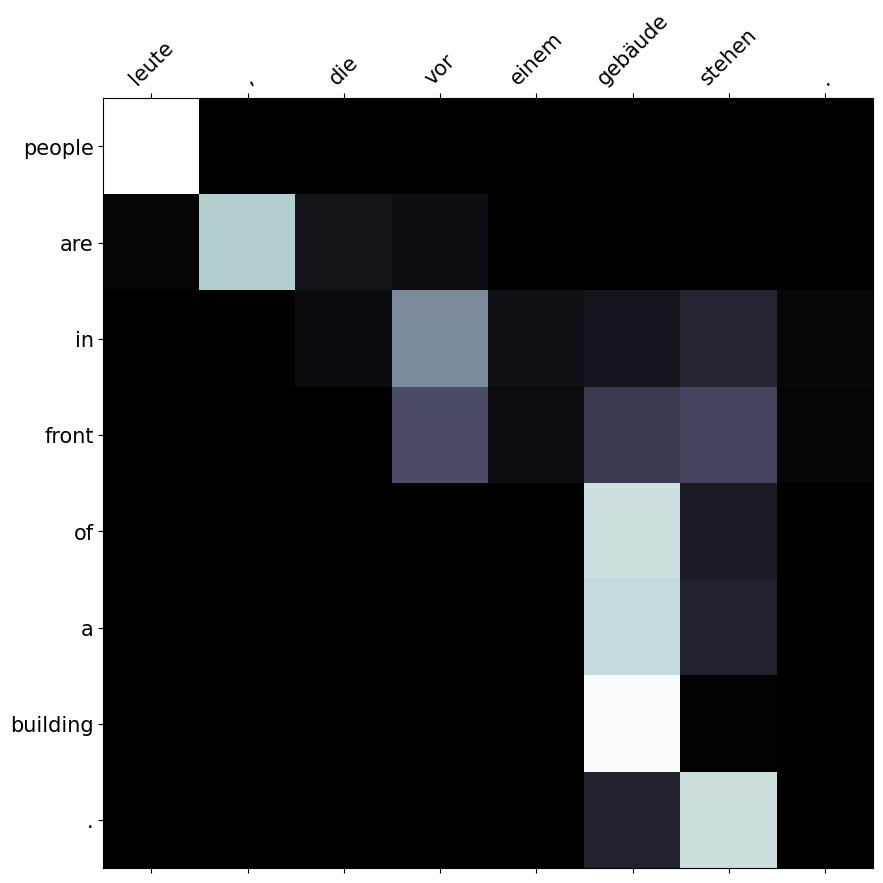

['<sos>', 'people', 'are', 'in', 'front', 'of', 'a', 'building', '.', '<eos>']

In [32]:
checkpoint_file = 'nmt-model-gru-attention-15.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(checkpoint_file)
predict(20, model, source_vocab, target_vocab, test_data, display_attn=True, debug=True)

In [33]:
cal_bleu_score(test_data, model, source_vocab, target_vocab)

BLEU Score: 25.09


## Class Activation Map

In [3]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00


In [4]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [5]:
# Download an image
!wget https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
# Set this to your image path if you wish to run it on your own data
img_path = "border-collie.jpg"

--2024-11-27 09:13:32--  https://www.woopets.fr/assets/races/000/066/big-portrait/border-collie.jpg
Resolving www.woopets.fr (www.woopets.fr)... 104.26.12.50, 172.67.73.8, 104.26.13.50, ...
Connecting to www.woopets.fr (www.woopets.fr)|104.26.12.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39710 (39K) [image/jpeg]
Saving to: ‘border-collie.jpg’

border-collie.jpg   100%[===================>]  38.78K  --.-KB/s    in 0.005s  

2024-11-27 09:13:33 (7.95 MB/s) - ‘border-collie.jpg’ saved [39710/39710]



In [6]:
# Instantiate your model here
model = resnet18(pretrained=True).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.8MB/s]


In [7]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [8]:
# Notice that there is one CAM per target layer (here only 1)
for cam in cams:
  print(cam.shape)

torch.Size([1, 7, 7])


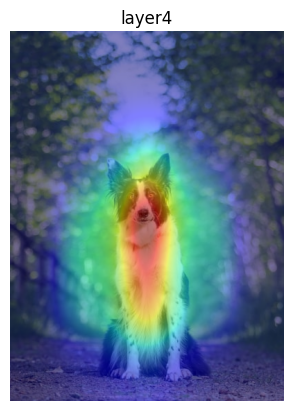

In [9]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

## Image Captioning (Show Attend and Tell)

In [1]:
%%capture
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip 'train2014.zip'
!rm -r 'train2014.zip'

!wget http://images.cocodataset.org/zips/val2014.zip
!unzip 'val2014.zip'
!rm -r 'val2014.zip'

# 가끔 오류 발생
!wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
!unzip 'caption_datasets.zip'
!rm -r 'caption_datasets.zip'

In [1]:
%matplotlib inline
import os
import sys
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage.transform
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("# of images [training]: {}".format(len(os.listdir("train2014"))))
print("# of images [validation]: {}".format(len(os.listdir("val2014"))))

# of images [training]: 82783
# of images [validation]: 40504


In [3]:
import json
from collections import Counter

# 데이터셋 파일을 로드합니다.
with open('dataset_coco.json', 'r') as f:
    data = json.load(f)

# 파라미터 설정
max_len = 100               # 캡션의 최대 길이 (패딩 포함)
image_folder = '/content'   # 훈련 및 검증 세트 이미지를 다운로드할 폴더
min_word_freq = 5           # 이 빈도보다 적게 나타나는 단어는 <unk>로 표시됩니다.
captions_per_image = 5      # 각 이미지당 생성될 캡션의 수
word_freq = Counter()       # 단어의 빈도를 계산하기 위한 Counter 객체

# 단어 맵을 생성합니다.
for img in data['images']:
    for c in img['sentences']:
        # 캡션에서 각 단어의 빈도를 업데이트합니다.
        word_freq.update(c['tokens'])

# 단어 맵을 생성합니다 (단어를 ID에 매핑하는 딕셔너리, 0은 패딩에 예약).
words = [word for word in word_freq.keys() if word_freq[word] > min_word_freq]
word2id = {word: id for id, word in enumerate(words, 1)}
word2id['<unk>'] = len(word2id) + 1  # 알 수 없는 단어를 위한 토큰
word2id['<start>'] = len(word2id) + 1  # 캡션 시작 토큰
word2id['<end>'] = len(word2id) + 1  # 캡션 종료 토큰
word2id['<pad>'] = 0  # 패딩 토큰

# ID를 단어로 매핑하는 역 단어 맵을 생성합니다.
id2word = {value: word for word, value in word2id.items()}

In [4]:
# 훈련, 검증, 테스트 데이터셋을 저장할 리스트를 초기화합니다.
train_image_paths = []
train_image_captions = []
train_caption_lens = []

val_image_paths = []
val_image_captions = []
val_caption_lens = []

test_image_paths = []
test_image_captions = []
test_caption_lens = []

# 데이터셋의 이미지를 반복하며 분할을 수행합니다.
for img in data['images']:
    captions = []

    # 캡션 길이가 max_len 이하인 경우만 선택합니다.
    for c in img['sentences']:
        if len(c['tokens']) <= max_len:
            captions.append(c['tokens'])

    # 캡션이 없는 이미지는 무시합니다.
    if len(captions) == 0:
        continue

    # 각 이미지에 대해 captions_per_image만큼의 캡션을 준비합니다.
    if len(captions) < captions_per_image:
        # 부족한 경우, 기존 캡션 중에서 랜덤하게 추가하여 captions_per_image를 충족합니다.
        captions += [random.choice(captions) for _ in range(captions_per_image - len(captions))]
    else:
        # 충분한 경우, captions_per_image만큼 랜덤 샘플링합니다.
        captions = random.sample(captions, k=captions_per_image)

    # sanity check: 각 이미지의 캡션 수는 captions_per_image와 같아야 합니다.
    assert len(captions) == captions_per_image

    # 캡션을 인코딩하고 패딩을 추가합니다.
    enc_captions = []
    caption_lens = []
    for caption in captions:
        # 캡션을 인코딩하며, 시작 및 종료 토큰을 추가하고 부족한 길이는 패딩으로 채웁니다.
        enc_caption = (
            [word2id['<start>']] +
            [word2id.get(word, word2id['<unk>']) for word in caption] +
            [word2id['<end>']] +
            [word2id['<pad>']] * (max_len - len(caption))
        )

        # 캡션 길이를 계산합니다 (시작 및 종료 토큰 포함).
        caption_len = len(caption) + 2

        enc_captions.append(enc_caption)
        caption_lens.append(caption_len)

    # 이미지의 절대 경로를 가져옵니다.
    path = os.path.join(image_folder, img['filepath'], img['filename'])

    # 이미지와 캡션 데이터를 분할된 데이터셋에 추가합니다.
    if img['split'] in {'train', 'restval'}:  # 훈련 데이터
        train_image_paths.append(path)
        train_image_captions.append(enc_captions)
        train_caption_lens.append(caption_lens)
    elif img['split'] == 'val':  # 검증 데이터
        val_image_paths.append(path)
        val_image_captions.append(enc_captions)
        val_caption_lens.append(caption_lens)
    elif img['split'] == 'test':  # 테스트 데이터
        test_image_paths.append(path)
        test_image_captions.append(enc_captions)
        test_caption_lens.append(caption_lens)

# 데이터 분할의 일관성을 검증합니다.
assert len(train_image_paths) == len(train_image_captions)
assert len(val_image_paths) == len(val_image_captions)
assert len(test_image_paths) == len(test_image_captions)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import cv2
import torch

class CaptionDataset(Dataset):
    def __init__(self, image_paths, captions, caption_lens, split, captions_per_image=5, transform=None):
        """
        이미지와 캡션 데이터셋을 처리하기 위한 PyTorch Dataset 클래스.

        Args:
        - image_paths: 이미지 경로 리스트.
        - captions: 인코딩된 캡션 리스트.
        - caption_lens: 캡션 길이 리스트.
        - split: 데이터셋의 분할 ('TRAIN', 'VAL', 'TEST').
        - captions_per_image: 각 이미지당 캡션 수.
        - transform: 이미지 변환(예: 정규화) 파이프라인.
        """
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}  # 분할 유형 확인

        self.image_paths = image_paths  # 이미지 경로 리스트
        self.captions = captions  # 캡션 리스트
        self.caption_lens = caption_lens  # 캡션 길이 리스트
        self.captions_per_image = captions_per_image  # 이미지당 캡션 수
        self.transform = transform  # 이미지 변환 설정

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환 (이미지 수 × 이미지당 캡션 수)
        return len(self.image_paths) * self.captions_per_image

    def __getitem__(self, idx):
        """
        주어진 인덱스에서 데이터 포인트를 반환합니다.
        """
        # idx 번째 캡션은 (idx // captions_per_image) 번째 이미지에 속합니다.
        img = Image.open(self.image_paths[idx // self.captions_per_image]).convert('RGB')  # 이미지 로드 및 RGB 변환
        img = np.array(img)  # 이미지를 NumPy 배열로 변환
        img = cv2.resize(img, (256, 256))  # 이미지를 256×256으로 리사이즈

        # sanity check: 이미지가 올바른 크기와 값 범위를 가지는지 확인
        assert img.shape == (256, 256, 3)
        assert np.max(img) <= 255.0

        # 변환 파이프라인 적용 (정규화 등)
        if self.transform is not None:
            img = self.transform(img)

        # 이미지를 텐서로 변환 (C, H, W 형태)
        # img = np.array(img)
        # img = np.transpose(img, (2, 0, 1))  # 채널 축을 앞으로 이동
        img = torch.FloatTensor(img / 255.0)  # 값을 [0, 1] 범위로 정규화

        # 현재 인덱스에 해당하는 캡션과 캡션 길이를 가져옵니다.
        caption = torch.LongTensor(self.captions[idx // self.captions_per_image][idx % self.captions_per_image])
        caption_len = torch.LongTensor([self.caption_lens[idx // self.captions_per_image][idx % self.captions_per_image]])

        if self.split == 'TRAIN':
            # 훈련 데이터에서는 이미지, 캡션, 캡션 길이를 반환합니다.
            return img, caption, caption_len
        else:
            # 검증 및 테스트 데이터에서는 모든 캡션을 반환하여 BLEU-4 점수를 계산할 수 있도록 합니다.
            all_captions = torch.LongTensor(self.captions[idx // self.captions_per_image])
            return img, caption, caption_len, all_captions


# 이미지 정규화 변환 파이프라인 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 사전 학습 모델에 맞춘 평균값
    #                      std=[0.229, 0.224, 0.225])   # ImageNet 사전 학습 모델에 맞춘 표준편차
])

# 훈련, 검증, 테스트 데이터셋 생성
train_dataset = CaptionDataset(train_image_paths, train_image_captions, train_caption_lens, 'TRAIN', transform=transform)
val_dataset = CaptionDataset(val_image_paths, val_image_captions, val_caption_lens, 'VAL', transform=transform)
test_dataset = CaptionDataset(test_image_paths, test_image_captions, test_caption_lens, 'TEST', transform=transform)

In [7]:
def decode_caption(enc_caption):
    dec_caption = [
        id2word[id]
        for id in caption.numpy()
        if id2word[id] not in ["<start>", "<end>", "<unk>", "<pad>"]
    ]
    return " ".join(dec_caption)

a woman marking a cake with the back of a chefs knife



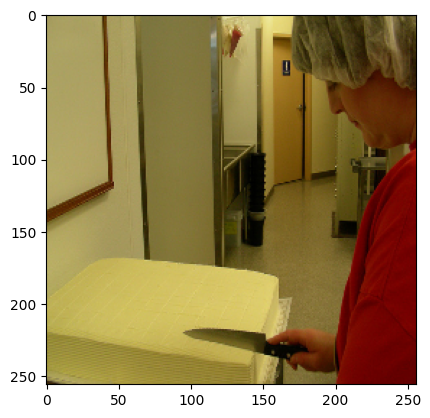

In [8]:
img, caption, caption_len = train_dataset[0]

print(decode_caption(caption))
print()
plt.imshow(img.permute(1, 2, 0) * 255);

a large fire hydrant on a truck



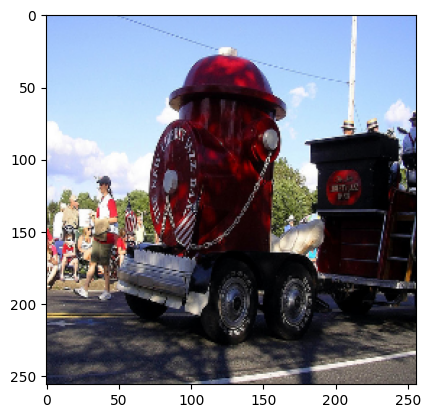

In [9]:
img, caption, caption_len = train_dataset[787]

print(decode_caption(caption))
print()
plt.imshow(img.permute(1, 2, 0) * 255);

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 사전 학습 모델에 맞춘 평균값
                         std=[0.229, 0.224, 0.225])   # ImageNet 사전 학습 모델에 맞춘 표준편차
])

# 훈련, 검증, 테스트 데이터셋 생성
train_dataset = CaptionDataset(train_image_paths, train_image_captions, train_caption_lens, 'TRAIN', transform=transform)
val_dataset = CaptionDataset(val_image_paths, val_image_captions, val_caption_lens, 'VAL', transform=transform)
test_dataset = CaptionDataset(test_image_paths, test_image_captions, test_caption_lens, 'TEST', transform=transform)

batch_size = 32
workers = 2

# dataloader for train and val set
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=workers, pin_memory=True)

# quick check to see if data is properly loaded or not
images, captions, caption_lens = next(iter(train_loader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 102])
torch.Size([32, 1])


### Model Architecture

In [11]:
import torchvision.models as models
import torch.nn as nn

class ImageEncoder(nn.Module):
    def __init__(self, enc_image_size=14):
        """
        이미지 인코더 클래스. 사전 학습된 ResNet-101을 사용하여 이미지를 고정된 크기의 특징 맵으로 변환합니다.
        :param enc_image_size: 출력 특징 맵의 크기 (enc_image_size x enc_image_size).
        """
        super(ImageEncoder, self).__init__()
        self.enc_image_size = enc_image_size

        # ImageNet에서 사전 학습된 ResNet-101 모델 로드
        resnet = models.resnet101(pretrained=True)

        # ResNet의 선형 레이어와 풀링 레이어 제거
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # 입력 이미지 크기가 가변적인 경우에도 고정된 크기로 조정하기 위해 Adaptive Average Pooling 사용
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))

        # 파인튜닝 설정
        self.fine_tune()

    def fine_tune(self, fine_tune=True):
        """
        ResNet의 특정 컨볼루션 블록에 대해 파인튜닝을 허용하거나 제한합니다.
        :param fine_tune: 파인튜닝 활성화 여부 (Boolean).
        """
        # ResNet의 모든 파라미터를 고정하여 업데이트되지 않도록 설정
        for param in self.resnet.parameters():
            param.requires_grad = False

        # 파인튜닝을 활성화한 경우, ResNet의 일부 블록에 대해 그래디언트 계산을 허용
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune

    def forward(self, images):
        """
        순전파 연산.
        :param images: 입력 이미지 텐서 (batch_size, 3, image_size, image_size).
        :return enc_images: 인코딩된 이미지 특징 맵 (batch_size, enc_image_size, enc_image_size, 2048).
        """
        # ResNet을 통해 특징 맵 추출
        out = self.resnet(images)       # (batch_size, 2048, image_size/32, image_size/32)

        # Adaptive Average Pooling으로 특징 맵 크기 조정
        out = self.adaptive_pool(out)   # (batch_size, 2048, enc_image_size, enc_image_size)

        # 텐서 차원을 변환하여 (batch_size, enc_image_size, enc_image_size, 2048) 형태로 만듦
        out = out.permute(0, 2, 3, 1)   # (batch_size, enc_image_size, enc_image_size, 2048)

        return out


In [12]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: 인코더 출력 특징의 크기
        :param decoder_dim: 디코더 RNN의 크기
        :param attention_dim: 어텐션 네트워크의 크기
        """
        super(BahdanauAttention, self).__init__()
        # 인코더 출력 특징을 변환하기 위한 선형 레이어
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)
        # 디코더 출력 특징을 변환하기 위한 선형 레이어
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)
        # 어텐션 점수를 계산하기 위한 선형 레이어
        self.full_attn = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        """
        순전파 연산을 수행합니다 (Multiplicative 어텐션을 사용).
        :param encoder_out: 인코더 출력, 텐서 형태 (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: 이전 디코더 은닉 상태, 텐서 형태 (batch_size, decoder_dim)
        """
        # 인코더 출력 특징을 어텐션 차원으로 변환
        attn1 = self.encoder_attn(encoder_out)  # (batch_size, num_pixels, attention_dim)
        # 디코더 은닉 상태를 어텐션 차원으로 변환
        attn2 = self.decoder_attn(decoder_hidden)  # (batch_size, attention_dim)
        # 인코더와 디코더 출력을 합산한 후 비선형 활성화 함수 적용
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))  # (batch_size, num_pixels, 1)
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))

        # 소프트맥스를 적용하여 어텐션 가중치를 계산
        alpha = F.softmax(attn, dim=1)  # (batch_size, num_pixels, 1)
        # 어텐션 가중치를 사용하여 인코더 출력을 가중 합산
        attn_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        # 어텐션 가중치의 마지막 차원을 제거
        alpha = alpha.squeeze(2)  # (batch_size, num_pixels)
        return attn_weighted_encoding, alpha

In [13]:
class DecoderWithAttention(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: 어텐션 네트워크의 크기
        :param embed_dim: 임베딩 크기
        :param decoder_dim: 디코더 RNN의 크기
        :param vocab_size: 어휘의 크기
        :param encoder_dim: 인코더 출력 특징의 크기
        :param dropout: 드롭아웃 비율
        """
        super(DecoderWithAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        # 어텐션 네트워크
        self.attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)
        # 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=dropout)

        # 디코딩을 위한 LSTMCell
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        # LSTMCell의 초기 은닉 상태를 생성하기 위한 선형 레이어
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        # LSTMCell의 초기 셀 상태를 생성하기 위한 선형 레이어
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        # 시그모이드 게이팅을 위한 선형 레이어
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        # 어휘에 대한 점수를 계산하는 선형 레이어
        self.fc = nn.Linear(decoder_dim, vocab_size)

        # 가중치 초기화
        self.init_weights()

    def init_weights(self):
        """
        가중치를 균등 분포로 초기화하여 더 빠른 수렴을 유도합니다.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        """
        인코더 출력 특징을 기반으로 LSTM의 초기 은닉 상태와 셀 상태를 생성합니다.
        :param encoder_out: 인코더 출력, 텐서 형태 (batch_size, num_pixels, encoder_dim)
        :return: 초기 은닉 상태와 셀 상태
        """
        mean_encoder_out = encoder_out.mean(dim=1)  # (batch_size, encoder_dim)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)  # (batch_size, decoder_dim)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lens):
        """
        순전파 연산을 수행합니다.
        :param encoder_out: 인코더 출력, 텐서 형태 (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: 인코딩된 캡션, 텐서 형태 (batch_size, max_caption_length)
        :param caption_lens: 캡션 길이, 텐서 형태 (batch_size, 1)
        :return: 어휘 점수, 정렬된 인코딩된 캡션, 디코딩 길이, 어텐션 가중치, 정렬 인덱스
        """
        batch_size = encoder_out.size(0)

        # 인코더 출력을 평탄화
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # 캡션 길이에 따라 입력 데이터를 내림차순으로 정렬
        caption_lens, sort_idx = caption_lens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_idx]
        encoded_captions = encoded_captions[sort_idx]

        # 임베딩 수행
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # LSTM 상태 초기화
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # 디코딩 길이는 캡션 길이에서 1을 뺀 값
        decode_lens = (caption_lens - 1).tolist()

        # 예측 점수와 어텐션 가중치를 저장할 텐서 생성
        predictions = torch.zeros(batch_size, max(decode_lens), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device)

        # 디코딩 루프: 어텐션을 적용하고 다음 단어를 생성
        for t in range(max(decode_lens)):
            batch_size_t = sum([l > t for l in decode_lens])  # 현재 시간 단계에서 유효한 배치 크기

            # 어텐션 가중치를 계산하고 인코더 출력을 가중합
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = F.sigmoid(self.f_beta(h[:batch_size_t]))  # 시그모이드 게이팅
            attention_weighted_encoding = gate * attention_weighted_encoding

            # 디코더의 LSTMCell을 통해 은닉 상태와 셀 상태 갱신
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t])
            )

            # 어휘 점수 예측
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)

            # 예측 점수와 어텐션 가중치를 저장
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lens, alphas, sort_idx


In [14]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [15]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [16]:
def save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        'epoch': epoch,
        'epochs_since_improvement': epochs_since_improvement,
        'bleu-4': bleu4,
        'encoder': encoder,
        'decoder': decoder,
        'encoder_optimizer': encoder_optimizer,
        'decoder_optimizer': decoder_optimizer
    }
    filename = 'image_captioning_checkpoint_' + str(epoch) + '.pth'
    torch.save(state, filename)
    # store the copy of best checkpoint
    if is_best:
        print('Saving the best model')
        torch.save(state, 'image_captioning_best.pth')

In [17]:
def train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    """
    Performs one epoch's training.
    :param train_loader: DataLoader for training data
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :param encoder_optimizer: optimizer to update encoder's weights (if fine-tuning)
    :param decoder_optimizer: optimizer to update decoder's weights
    :param epoch: epoch number
    """
    losses = []
    top5accs = []

    # train mode (dropout and batchnorm is used)
    decoder.train()
    encoder.train()

    for i, (imgs, caps, cap_lens) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # move tensor to GPU if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        cap_lens = cap_lens.to(device)

        # forward prop
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)

        # since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # remove timesteps that we didn't decode at, or are pads
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # calculate the loss
        loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # backprop
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # clip gradients
        if grad_clip is not None:
            clip_gradient(decoder_optimizer, grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, grad_clip)

        # update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # keep track of metrics
        top5 = accuracy(scores, targets, 5)
        losses.append(loss.item())
        top5accs.append(top5)

    return np.mean(losses), np.mean(top5accs)


In [18]:
def val_epoch(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    losses = []
    top5accs = []

    # eval mode (no dropout or batchnorm)
    decoder.eval()
    if encoder is not None:
        encoder.eval()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation
    with torch.no_grad():
        for i, (imgs, caps, cap_lens, all_caps) in enumerate(tqdm(val_loader, total=len(val_loader))):
            # move tensor to GPU if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            cap_lens = cap_lens.to(device)

            # forward prop
            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, cap_lens)

            # since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # remove timesteps that we didn't decode at, or are pads
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # calculate the loss
            loss = criterion(scores, targets) + alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

            # keep track of metrics
            top5 = accuracy(scores, targets, 5)
            losses.append(loss.item())
            top5accs.append(top5)

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
            # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

            # references
            all_caps = all_caps[sort_ind]  # because images were sorted in the decoder
            for j in range(all_caps.shape[0]):
                img_caps = all_caps[j].tolist()
                img_captions = list(
                    map(lambda caption: [word for word in caption if word not in {word2id['<start>'], word2id['<pad>']}],
                        img_caps))  # remove <start> and pads
                references.append(img_captions)

            # hypotheses
            _, preds = torch.max(scores_copy, dim=2)
            preds = preds.tolist()
            temp_preds = list()
            for j, pred in enumerate(preds):
                temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
            hypotheses.extend(temp_preds)

            # sanity check
            assert len(references) == len(hypotheses)

        # calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)

    return np.mean(losses), np.mean(top5accs), bleu4


In [19]:
# model parameters
embed_dim = 512      # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512    # dimension of decoder RNN
encoder_dim = 2048
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
grad_clip = 5.  # clip gradients at an absolute value of
alpha_c = 1.  # regularization parameter for 'doubly stochastic attention', as in the paper
vocab_size = len(word2id)
best_bleu4 = 0.  # BLEU-4 score right now
lr_decay_factor = 0.8
lr_decay_patience = 8
best_bleu4 = 0

start_epoch = 1
num_epochs = 20
epochs_since_improvement = 0  # keeps track of number of epochs since there's been an improvement in validation BLEU

fine_tune_encoder = False  # fine-tune encoder?
checkpoint = None  # image_captioning_best.pth
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead


# checkpoint
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim)
    decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

    encoder = ImageEncoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)

    start_epoch = checkpoint['epoch'] + 1
    best_bleu4 = checkpoint['bleu-4']
    encoder = checkpoint['encoder']
    decoder = checkpoint['decoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder_optimizer = checkpoint['decoder_optimizer']

    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr)


encoder = encoder.to(device)
decoder = decoder.to(device)

# lr scheduler
encoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None
decoder_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)

# criterion for loss
criterion = nn.CrossEntropyLoss().to(device)

# loop
for epoch in range(start_epoch, num_epochs + 1):
    loss_train, acc_train = train_epoch(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer)
    loss_val, acc_val, bleu4_val = val_epoch(val_loader, encoder, decoder, criterion)

    # reduce the learning rate on plateau
    decoder_lr_scheduler.step(bleu4_val)
    if fine_tune_encoder:
        encoder_lr_scheduler.step(bleu4_val)

    # check if there was an improvement
    is_best = bleu4_val > best_bleu4
    best_bleu4 = max(bleu4_val, best_bleu4)
    if not is_best:
        epochs_since_improvement += 1
    else:
        epochs_since_improvement = 0

    print('-' * 40)
    print(f'epoch: {epoch}, train loss: {loss_train:.4f}, train acc: {acc_train:.2f}%, valid loss: {loss_val:.4f}, valid acc: {acc_val:.2f}%, best BLEU-4: {best_bleu4:.4f}')
    print('-' * 40)

    # save the checkpoint
    save_checkpoint(epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer,
                    decoder_optimizer, bleu4_val, is_best)

  0%|          | 0/17702 [00:00<?, ?it/s]

KeyboardInterrupt: 